In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Display the row's columns and data in dictionary format
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x222c63a1b70>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [11]:
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Display the row's columns and data in dictionary format
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x222c63e0b70>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397',
 'elevation': 3.0,
 'latitude': 21.2716,
 'id': 1}

In [13]:
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



# Design a query to retrieve the last 12 months of precipitation data and plot the results

Calculate the date 1 year ago from the last data point in the database
Perform a query to retrieve the data and precipitation scores
Save the query results as a Pandas DataFrame and set the index to the date column
Sort the dataframe by date
Use Pandas Plotting with Matplotlib to plot the data

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# what is the most recent date in the file
date_to = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(date_to)

('2017-08-23',)


In [15]:
# Calculate the date 1 year ago from the last data point in the database

date_start = dt.date(2017,8,23) - dt.timedelta(days=364)
print(date_start)

2016-08-24


In [16]:
# Perform a query to retrieve the data and precipitation scores
past_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_start)

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df=pd.DataFrame(past_year, columns = ['Date','Precipitation'])
prcp_df

,Date,Precipitation
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01
...,...,...
2218,2017-08-19,0.09
2219,2017-08-20,NaN
2220,2017-08-21,0.56
2221,2017-08-22,0.50


In [17]:
# reset NaN columns to 0 or remove them?
df=prcp_df.isnull().sum()
print(df)


Date               0
Precipitation    208
dtype: int64


In [18]:
#drop all rows where the prcp is null or NaN, on the presumption that it is NOT a legitimate reading
clean_prcp_df=prcp_df.dropna()
clean_prcp_df


,Date,Precipitation
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01
...,...,...
2216,2017-08-17,0.13
2218,2017-08-19,0.09
2220,2017-08-21,0.56
2221,2017-08-22,0.50


In [19]:
# set the index to the date column
prcp_indexed_df=clean_prcp_df.set_index('Date')
prcp_indexed_df.dtypes
# Sort the dataframe by date
prcp_indexed_df.index
prcp_indexed_df.sort_index(inplace=True)
prcp_indexed_df

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,1.22
2016-08-24,2.28
2016-08-24,1.45
2016-08-24,2.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


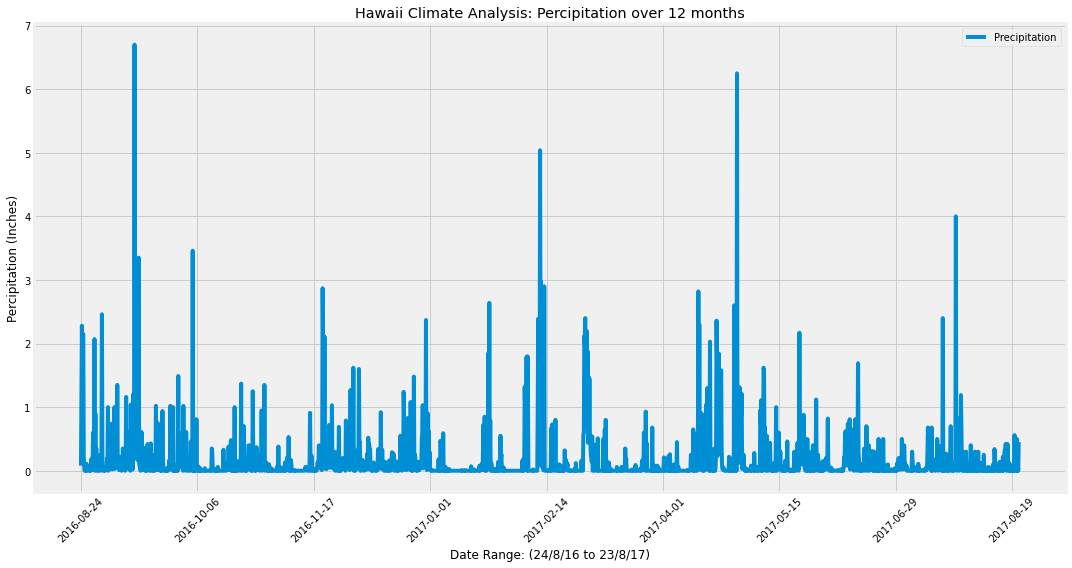

In [20]:
# Use Pandas Plotting with Matplotlib to plot the data
#Determine the plot size
prcp_indexed_df.plot(figsize=(15,8))
plt.grid(True)
plt.xticks(rotation='45')
plt.xlabel("Date Range: (24/8/16 to 23/8/17)")
plt.ylabel("Percipitation (Inches)")
plt.title("Hawaii Climate Analysis: Percipitation over 12 months")
plt.legend()
plt.tight_layout()

plt.show()



In [21]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_indexed_df.describe()


,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


 From this point on, I was a little unclear in the intrepretation of "in this dataset".
 Was it intented to mean 'in this dataset of 12 months only, with non value records removed'
 or was it intended to mean in the orginal dataset covering a number of years.
 reading on, I have presumed it is the original dataset, 
 given the 'last 12 months' reference a few lines down

In [22]:
# Design a query to show how many stations are available in this dataset?
unique_stations=session.query(Measurement.station).distinct().count()

print(f'Stations available in this dataset: {unique_stations}')

Stations available in this dataset: 9


In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_readings = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

station_readings

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active_min = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281' ).all()
most_active_max = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281' ).all()
most_active_avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281' ).all()
print('In the most active station:')
print(f' the minumum tobs was: {most_active_max}')
print(f' the maximum was {most_active_min},')
print(f' and the average was {most_active_avg}')


In the most active station:
 the minumum tobs was: [(85.0,)]
 the maximum was [(54.0,)],
 and the average was [(71.66378066378067,)]


In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
# and plot the results as a histogram

temp = session.query(Measurement.station,Measurement.tobs).filter(Measurement.date >= date_start)
temp_df=pd.DataFrame(temp, columns = ['station', 'tobs'])
temp_station_df= temp_df[(temp_df['station']=='USC00519281')]
top_station_df=temp_station_df.drop('station', 1)
top_station_df

,tobs
1524,77.0
1525,80.0
1526,80.0
1527,75.0
1528,73.0
...,...
1870,77.0
1871,77.0
1872,76.0
1873,76.0


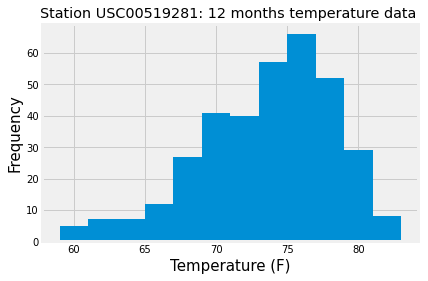

<Figure size 720x360 with 0 Axes>

In [26]:
top_station_df.hist(bins=12)
plt.title("Station USC00519281: 12 months temperature data ")
plt.ylabel("Frequency",fontsize=15)
plt.xlabel("Temperature (F)",fontsize=15)
plt.figure(figsize=[10,5])
plt.show()

## Bonus Challenge Assignment

In [35]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
